In [251]:
from scipy.signal import stft
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.optimize import curve_fit
import tensorflow as tf

In [252]:
# 定义多项式函数
def fitting_model_func(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e


# Convert quaternion to rotation matrix
def rotation_matrix(quat):
    rot_mat = np.ones([3,3])
    a = quat[0]**2
    b = quat[1]**2
    c = quat[2]**2
    d = quat[3]**2
    e = quat[0]*quat[1]
    f = quat[0]*quat[2]
    g = quat[0]*quat[3]
    h = quat[1]*quat[2]
    i = quat[1]*quat[3]
    j = quat[2]*quat[3]
    rot_mat[0,0] = a - b - c + d
    rot_mat[0,1] = 2 * (e - j)
    rot_mat[0,2] = 2 * (f + i)
    rot_mat[1,0] = 2 * (e + j)
    rot_mat[1,1] = -a + b - c + d
    rot_mat[1,2] = 2 * (h - g)
    rot_mat[2,0] = 2 * (f - i)
    rot_mat[2,1] = 2 * (h + g)
    rot_mat[2,2] = -a - b + c + d
    
    return rot_mat


# 创建旋转矩阵
def rpy2Rotation(roll, pitch, yaw):
    rotation_matrix = np.array([
        [np.cos(yaw)*np.cos(pitch), -np.sin(yaw)*np.cos(roll) + np.cos(yaw)*np.sin(pitch)*np.sin(roll), np.sin(yaw)*np.sin(roll) + np.cos(yaw)*np.sin(pitch)*np.cos(roll)],
        [np.sin(yaw)*np.cos(pitch), np.cos(yaw)*np.cos(roll) + np.sin(yaw)*np.sin(pitch)*np.sin(roll), -np.cos(yaw)*np.sin(roll) + np.sin(yaw)*np.sin(pitch)*np.cos(roll)],
        [-np.sin(pitch), np.cos(pitch)*np.sin(roll), np.cos(pitch)*np.cos(roll)]
    ])
    return rotation_matrix

def getFw(imu_data):
    # Transform the rotation speed(RPM) from test data(PWM) of Crazyflie document: PWM to RPM
    x = np.linspace(0-6.25,93.75,int(93.75/6.25)+2)/100
    y = np.array([-5000, 0, 4485, 7570, 9374, 10885, 12277, 13522, 14691, 15924, 17174, 18179, 19397, 20539, 21692, 22598, 23882])
    # Curve fitting to get the parameters of polynomial
    params, params_covariance = curve_fit(fitting_model_func, x, y)
    RPM = fitting_model_func(np.asarray(imu_data[:,6:10]), params[0], params[1], params[2], params[3], params[4])

    R = np.zeros([imu_data.shape[0], 3, 3])
    for i in range(imu_data.shape[0]):
        R[i, :, :] = rotation_matrix([0,0,0,1])


    m = 0.0362 # Mass of the whole drone
    g = 9.83 # Gravity acceleration
    rho = 1.01 # Air density
    D = 0.048  # Diameter of the rotor
    RPM2RS = 60 ** 2 # Ratio of converting motor rotation speed from minute to seconds

    C_t_fixed = 0.09937873049125099
    Fa = np.zeros([imu_data.shape[0], 3])
    F = R[:, :, 2]

    for i in range(imu_data.shape[0]):
        F_whole = m * imu_data[i, 0:3]/1000  # F_whole = ma + mg, the direction is downward along z-axis
        # temp[2] += m * g
        r_square = RPM[i, 0]**2 + RPM[i, 1]**2 + RPM[i, 2]**2 + RPM[i, 3]**2
        thrust = C_t_fixed / RPM2RS * rho * D ** 4 * r_square # c_t = C_t_fixed / rpm2rs * rho * D ** 4. r_square = n**2+n**2+n**2+n**2
        Fa[i, :] = F_whole - thrust * F[i, :]

    return Fa



def cfar_so(xc, LW_Size, Guard_Size, PFA):
    alpha = LW_Size * (PFA ** (-1 / LW_Size) - 1)
    # target = []
    # index = np.arange(1 + LW_Size/2 + Guard_Size/2, len(xc) - LW_Size/2 - Guard_Size/2)
    # CFAR_Threshold = np.zeros(len(index))

    # for i in index:
    cell_left = xc[int(-1 - LW_Size/2 - Guard_Size/2) : int(-1 - Guard_Size/2)]
    # cell_right = xc[int(i + Guard_Size/2 + 1) : int(i + N/2 + Guard_Size/2 + 1)]
    cell_right = 1e10
    Z = np.min([np.mean(cell_left), np.mean(cell_right)])
    # print(alpha)
    # CFAR_Threshold[int(-1 - LW_Size/2 - Guard_Size/2-1)] = Z * alpha
    if xc[-1] > Z * alpha:
        Fw_detected = True
    else:
        Fw_detected = False
    return Fw_detected



In [253]:

    
def process(imu_data):
    
    # acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, motor1, motor2, motor3, motor4, quat, current_time, height
    # Normalizing the PWM
    imu_data[:,6:10] = imu_data[:,6:10]/((1<<16)-1)
    nperseg=99
    noverlap=98

    # ****************** Section 4 Ground Effect Profiling from Motors and IMU ****************
    # Section 4.2  Fluctuation Components Feature Extraction (FC-FE).

    # STFT for each sensor data
    _, _, Zxx_1 = stft(imu_data[:,0], fs=100, nperseg=nperseg, noverlap=noverlap)
    extracted_data_1 = np.sum(abs(Zxx_1[12:17,1]**2),axis=0)

    _, _, Zxx_2 = stft(imu_data[:,1], fs=100, nperseg=nperseg, noverlap=noverlap)
    extracted_data_2 = np.sum(abs(Zxx_2[12:17,:]**2),axis=0)

    _, _, Zxx_3 = stft(imu_data[:,2], fs=100, nperseg=nperseg, noverlap=noverlap)
    extracted_data_3 = np.sum(abs(Zxx_3[12:17,:]**2),axis=0)

    _, _, Zxx_4 = stft(imu_data[:,3], fs=100, nperseg=nperseg, noverlap=noverlap)
    extracted_data_4 = np.sum(abs(Zxx_4[12:17,:]**2),axis=0)

    _, _, Zxx_5 = stft(imu_data[:,4], fs=100, nperseg=nperseg, noverlap=noverlap)
    extracted_data_5 = np.sum(abs(Zxx_5[12:17,:]**2),axis=0)

    _, _, Zxx_6 = stft(imu_data[:,5], fs=100, nperseg=nperseg, noverlap=noverlap)
    extracted_data_6 = np.sum(abs(Zxx_6[12:17,:]**2),axis=0)

    _, _, Zxx_7 = stft(imu_data[:,7]-imu_data[:,6], fs=100, nperseg=nperseg, noverlap=noverlap)
    extracted_data_7 = np.sum(abs(Zxx_7[12:17,:]**2),axis=0)

    _, _, Zxx_8 = stft(imu_data[:,8]-imu_data[:,6], fs=100, nperseg=nperseg, noverlap=noverlap)
    extracted_data_8 = np.sum(abs(Zxx_8[12:17,:]**2),axis=0)

    _, _, Zxx_9 = stft(imu_data[:,9]-imu_data[:,6], fs=100, nperseg=nperseg, noverlap=noverlap)
    extracted_data_9 = np.sum(abs(Zxx_9[12:17,:]**2),axis=0)



    # Section 4.3 Cascaded Cross-Spectrum Feature Fusion (CCS-FF).
    fusion_acc = np.array(extracted_data_1*extracted_data_2*extracted_data_3)[-1]
    fusion_gyro = np.array(extracted_data_4*extracted_data_5*extracted_data_6)[-1]
    fusion_motor = np.array(extracted_data_7*extracted_data_8*extracted_data_9)[-1]


    # ****************** Section 5 Physical Knowledge-Aided Light Weight Predictor ****************
    # Section 5.1 Aerodynamiccs-Informed Double Phase Physical Filter
    # Calculate the disturbance force in Z axis
    Fw_raw = getFw(imu_data)[:,2] # only take values on z-axis
    Fw_isdeteced = cfar_so(Fw_raw, LW_Size=100, Guard_Size=15, PFA=1e-6)
   
   
    return fusion_acc, fusion_gyro, fusion_motor, Fw_isdeteced



In [254]:
model = tf.saved_model.load("/home/nuc0428/project/archive4cf/EdgeDetectionCNN/fusion_3sensor/saved/150_81616_16normalization_epoch200")

In [259]:
input_folder = "/home/nuc0428/project/AirTouch/crazyflie_filter_constant/control/data/"
output_folder = "/home/nuc0428/project/AirTouch/crazyflie_filter_constant/control/temp4real/"
imu_data = np.loadtxt(input_folder+"imu_data_0102-2131.csv", delimiter=',')


seg_size = 100
fusion_acc = np.zeros(imu_data.shape[0]-seg_size)
fusion_gyro = np.zeros(imu_data.shape[0]-seg_size)
fusion_motor = np.zeros(imu_data.shape[0]-seg_size)

queue = []
consecutive_zeros = 0
consecutive_ones = 0
predicted_class = []
for i in range(np.shape(imu_data)[0]-seg_size):
    fusion_acc[i],fusion_gyro[i],fusion_motor[i],_ = process(imu_data[i:i+seg_size,:])
    queue.append([fusion_acc[i],fusion_gyro[i],fusion_motor[i]])
    if len(queue) > 100:
        queue.pop(0)
    if len(queue) == 100:
        # 计算队列中特征的均值和标准差
        queue_array = np.array(queue).reshape(100, 3).astype(np.float32)
        mean = np.mean(queue_array, axis=0)
        std = np.std(queue_array, axis=0)
        # 归一化特征
        normalized_features = (queue_array - mean) / std

        # 使用归一化后的特征进行模型预测
        result = model(normalized_features.reshape(1, 100, 3))
        predicted_class.append(tf.argmax(result, axis=1)[0].numpy())
        # if predicted_class == 1 and entry_point:
        #     consecutive_ones += 1
        #     if consecutive_ones ==1:
        #         start_one = df.iloc[index, -2]
        #     if consecutive_ones >=15:
        #         # print("第一次预测为1时，时间：", start_one)
        #         entry_point = False
        # if predicted_class == 0 and entry_point:
        #     consecutive_ones = 0
        # if predicted_class == 0 and entry_point == False:
        #     consecutive_zeros += 1
        #     if consecutive_zeros == 1:
        #         start_time = df.iloc[index, -2]
        #     if consecutive_zeros >=20:
        #         result_list.append({'file_name': file_name, 'entry': start_one, 'exit': start_time})
        #         # result_list.append({'exit': start_time})
        #         break
        # if predicted_class == 1 and entry_point == False:
        #     consecutive_zeros = 0
        # print(predicted_class)
    

/tmp/ipykernel_142829/3643777273.py:26: RuntimeWarning: invalid value encountered in divide
  normalized_features = (queue_array - mean) / std


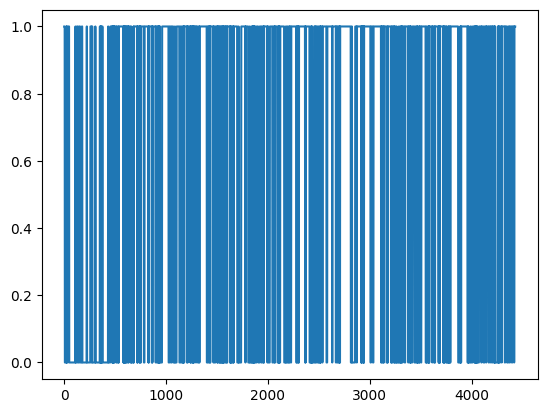

In [260]:
plt.plot(predicted_class)

In [236]:
# input_folder = "/home/nuc0428/project/AirTouch/crazyflie_filter_constant/control/data/"
# output_folder = "/home/nuc0428/project/AirTouch/crazyflie_filter_constant/control/temp4real/"
# imu_data = np.loadtxt(input_folder+"imu_data_0102-2131.csv", delimiter=',')

In [237]:
# bbb.shape[0]

In [238]:
# aaa = np.fft.fft(imu_data[:200,:])

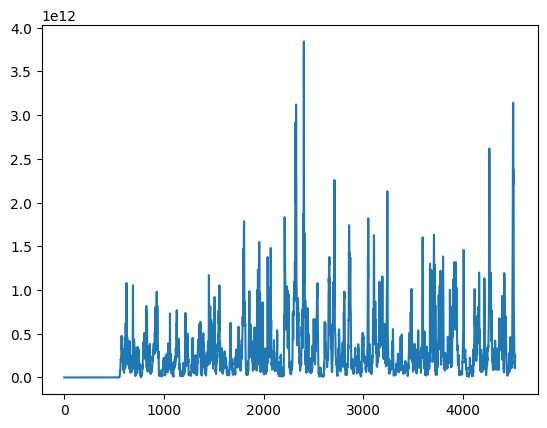

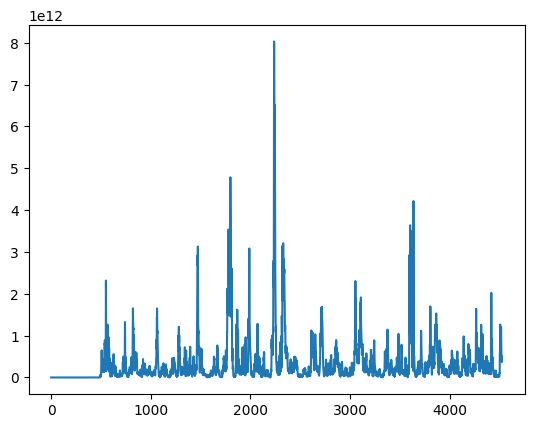

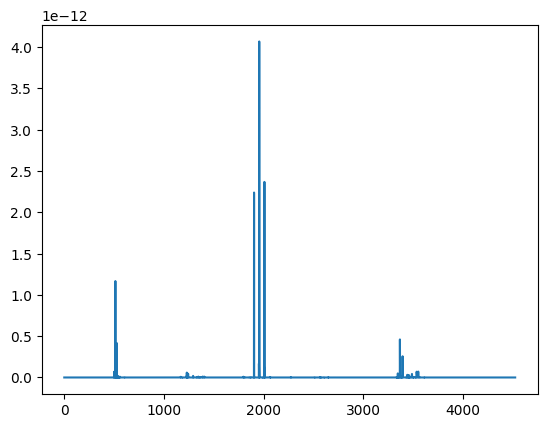

In [250]:
plt.plot(fusion_acc)
plt.figure()
plt.plot(fusion_gyro)
plt.figure()
plt.plot(fusion_motor)

In [ ]:

feature_tuple = (row[0], row[1], row[2])  # 提取两列数据作为一个特征元组
queue.append(feature_tuple)

if len(queue) > 100:
    queue.pop(0)
if len(queue) == 100:
    # 计算队列中特征的均值和标准差
    queue_array = np.array(queue).reshape(100, 3).astype(np.float32)
    mean = np.mean(queue_array, axis=0)
    std = np.std(queue_array, axis=0)
    # 归一化特征
    normalized_features = (queue_array - mean) / std

    # 使用归一化后的特征进行模型预测
    result = model(normalized_features.reshape(1, 100, 3))
    predicted_class = tf.argmax(result, axis=1)[0].numpy()
    if predicted_class == 1 and entry_point:
        consecutive_ones += 1
        if consecutive_ones ==1:
            start_one = df.iloc[index, -2]
        if consecutive_ones >=15:
            # print("第一次预测为1时，时间：", start_one)
            entry_point = False
    if predicted_class == 0 and entry_point:
        consecutive_ones = 0
    if predicted_class == 0 and entry_point == False:
        consecutive_zeros += 1
        if consecutive_zeros == 1:
            start_time = df.iloc[index, -2]
        if consecutive_zeros >=20:
            result_list.append({'file_name': file_name, 'entry': start_one, 'exit': start_time})
            # result_list.append({'exit': start_time})
            break
    if predicted_class == 1 and entry_point == False:
        consecutive_zeros = 0